# Credit Risk Modeling - LGD and EAD Models and Calculating Expected Loss

To build models for **loss given default (LGD)** and for **exposure at default (EAD)**, we only need accounts that have been written-off and a sufficient amount of time has passed so there can be some recoveries.
- **LGD:** the percentage of the exposure that was lost after the borrower defaulted
- **EAD:** the amount of the exposure at the moment the borrower defaulted

**Import Libraries**

In [4]:
import numpy as np
import pandas as pd

**Import Data**

In [5]:
# Import data.
loan_data_preprocessed_backup = pd.read_csv('loan_data_2007_2014_preprocessed.csv')

C:\Users\My Pham\AppData\Local\Temp\ipykernel_2512\52255634.py:2: DtypeWarning: Columns (21,49) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data_preprocessed_backup = pd.read_csv('loan_data_2007_2014_preprocessed.csv')


**Explore Data**

In [6]:
loan_data_preprocessed = loan_data_preprocessed_backup.copy()

In [7]:
# Displays all column names
loan_data_preprocessed.columns.values

array(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'member_id', 'loan_amnt',
       'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_join

In [8]:
loan_data_preprocessed.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,0,0,0,0,0,0,1,0,1
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,1,0,0
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,0,0,0,0,0,1,0,1
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,0,0,0,0,0,1,0,1
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,0,0,0,0,0,1,0,1


In [9]:
loan_data_preprocessed.tail()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
466280,466280,466280,8598660,1440975,18400,18400,18400.0,60 months,14.47,432.64,...,0,0,0,0,0,0,0,0,1,1
466281,466281,466281,9684700,11536848,22000,22000,22000.0,60 months,19.97,582.50,...,0,0,0,0,0,0,0,1,0,0
466282,466282,466282,9584776,11436914,20700,20700,20700.0,60 months,16.99,514.34,...,0,0,0,0,0,0,0,1,0,1
466283,466283,466283,9604874,11457002,2000,2000,2000.0,36 months,7.90,62.59,...,0,0,0,0,0,0,0,0,1,1
466284,466284,466284,9199665,11061576,10000,10000,9975.0,36 months,19.20,367.58,...,0,0,0,0,0,0,0,1,0,1


It wouldn't be entirely accurate to include all accounts for LGD and EAD. After a borrower has defaulted, they can repay part of the debt so the lender can recover part of the amount they thought would be lost.

Therefore, when building LGD and EAD models, it is a good practice to build models with data from borrowers that have had enough time to repay part of the remaining debt. In our data, these are only the accounts that were written-off. Their 'loan_status' is 'Charged Off' and 'Does not meet the credit policy. Status:Charged Off'.

By selecting only these observations, we would have chosen the data for building LGD and EAD models.

In [10]:
# Take only the accounts that were charged-off (written-off)
loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])]

In [11]:
loan_data_defaults.shape

(43236, 209)

In [12]:
# Set the pandas dataframe options to display all columns/rows
pd.options.display.max_rows = None

In [13]:
loan_data_defaults.isnull().sum()

Unnamed: 0.1                                                           0
Unnamed: 0                                                             0
id                                                                     0
member_id                                                              0
loan_amnt                                                              0
funded_amnt                                                            0
funded_amnt_inv                                                        0
term                                                                   0
int_rate                                                               0
installment                                                            0
grade                                                                  0
sub_grade                                                              0
emp_title                                                           3287
emp_length                                         

The independent variables that we're going to use for LGD and EAD are the same that we used for the PD. These variables do not have to be only variables like they were in the PD model. 

For the discrete variables, we will create dummy variables, but this time we won't care about the weight of evidence or any other criteria to group the categories. Rather, we'll simply create as many dummy variales as there are categories.

For continuous variables, we can use them in the LGD and EAD models as they are or transform them. There's no need for fine classing and coarse classing.

## Independent Variables

In [14]:
# Fill the missing values with zeroes
loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace = True)

C:\Users\My Pham\AppData\Local\Temp\ipykernel_2512\1127906613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace = True)


In [15]:
#loan_data_defaults['mths_since_last_delinq'].fillna(loan_data_defaults['mths_since_last_delinq'].max() + 12, inplace=True)

In [16]:
# Fill the missing values with zeroes
loan_data_defaults['mths_since_last_record'].fillna(0, inplace=True)

C:\Users\My Pham\AppData\Local\Temp\ipykernel_2512\1127508641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['mths_since_last_record'].fillna(0, inplace=True)


## Dependent Variables

$$EL = PD \times LGD \times EAD$$
In practice, we're only going to be working on one of these models at a time. Thus, we'll use one dataset for storing the data needed for both models.

For example, let's start with loss given default (LGD = $500,000). It is the share of an asset that is lost if a borrower defaults. It is the proportion of the total exposure  that can be recovered by the lender. The established approach in practice is to model this proportion:

$$\text{Recovery Rate} = \% \text{ of Exposure Recovered}= 1 - \% \text{ of Exposure Not Recovered (LGD)}$$
$$\text{LGD = 1 - Recovery Rate}$$

We assume that for defaulted borrowers, 'funded_amnt' reflects the total amount that was lost the moment the borrower defaulted.

$$\text{Recovery Rate}=\frac{\text{recoveries}}{\text{funded amount}}$$

In [17]:
# Calculate the dependent variable for the LGD model: recovery rate - the ratio of recoveries and funded amount
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']

C:\Users\My Pham\AppData\Local\Temp\ipykernel_2512\2015564742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']


In [18]:
# Show some descriptive statisics for the values of a column
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

In [19]:
# Set recovery rates (ranging from 0 to 1) that are greater than 1 to 1 and recovery rates that are less than 0 to 0
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])

C:\Users\My Pham\AppData\Local\Temp\ipykernel_2512\3816234254.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
C:\Users\My Pham\AppData\Local\Temp\ipykernel_2512\3816234254.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])


In [20]:
# Show some descriptive statisics for the values of a column
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: recovery_rate, dtype: float64

The exposure at default (EAD) is the total value that a lender is exposed to when a borrower defaults. It is the maximum that a bank may lose when a borrower defaults on a loan.

On many occasions, the bank has decided to grant an amount of money, but the lender has not disbursed the whole amount. Also, the borrower may have repaid a significant amount of the debt at the time of default. 

Moreover, for revolving facilities such as credit cards, but also for some consumer loans, the borrower may be able to repay and spend what they had already repaid again, up to a certain limit called credit limit. 

So the borrower may only have defaulted on a proportion of the original funded amount. This proportion is our dependent variable for the exposure at default model.
$$\text{Total Exposure at Default = Default at a \% of the funded amount = Credit Conversion Factor (CCF) }$$
$$\text{EAD = total funded amount x credit conversion factor}$$

In our data, 'Total recovered' reflects the total payments made on the principal of the loan. Hence, if a borrower defaults, they would only have to repay the funded amount less the payments made on the principal, as this is the money they've already paid.

In [21]:
# Calculate the dependent variable (credit conversion factor) - the ratio of the difference of the amount used at the moment of default to the total funded amount
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']

C:\Users\My Pham\AppData\Local\Temp\ipykernel_2512\519673980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']


In [22]:
# Show some descriptive statisics for the values of a column
loan_data_defaults['CCF'].describe()

count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: CCF, dtype: float64

In [23]:
# Save the data to a CSV file
loan_data_defaults.to_csv('loan_data_defaults.csv')

**Distribution of Recovery Rates and Credit Conversion Factors:** Beta regression and other modeling approaches

**Beta Regression:** 
- The density of proportions is best described as beta distribution (X=[0,1]). The regression model used to assess the impact of a set of independent variables on a variable with beta distribution is called beta regression.
- Normally, it is used to model outcomes that are strictly greater than 0 and strictly lower than 1. However, some alterations allow for modeling outcomes that are greater than or equal to 0 and lower than or equal to 1, which is typically the case with recovery rate and credit conversion factor.

**Other Modeling Approaches**
- Currently, Python doesn't have a library to calculate this. We can borrow R's capabilities for this purpose such as r pi, but it takes up a lot of RAM. Therefore, we'll use statistical models instead:
  - **Logistic Regression:** $$ln(\frac{Y=1}{Y=0})=β_0+β_1X_1+β_2X_2+...+β_mX_m$$
  - **Linear Regression:** $$Y=β_0+β_1X_1+β_2X_2+...+β_mX_m$$

**Explore Dependent Variables**

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

(array([2.0651e+04, 3.7200e+02, 6.4200e+02, 1.1950e+03, 1.9300e+03,
        1.9430e+03, 6.4500e+02, 7.4900e+02, 8.9700e+02, 1.2360e+03,
        1.5530e+03, 1.7910e+03, 2.3140e+03, 2.4510e+03, 1.0410e+03,
        6.7200e+02, 7.0600e+02, 4.7300e+02, 1.9600e+02, 2.1000e+02,
        1.8600e+02, 1.5500e+02, 1.5900e+02, 1.1500e+02, 5.6000e+01,
        6.1000e+01, 4.2000e+01, 5.1000e+01, 4.6000e+01, 3.5000e+01,
        4.0000e+01, 3.3000e+01, 2.9000e+01, 2.5000e+01, 3.2000e+01,
        4.0000e+01, 2.7000e+01, 3.0000e+01, 1.6000e+01, 1.4000e+01,
        2.7000e+01, 2.0000e+01, 1.7000e+01, 1.0000e+01, 6.0000e+00,
        1.1000e+01, 5.0000e+00, 1.0000e+01, 1.1000e+01, 9.0000e+00,
        1.2000e+01, 1.1000e+01, 9.0000e+00, 8.0000e+00, 3.0000e+00,
        4.0000e+00, 3.0000e+00, 8.0000e+00, 2.0000e+00, 5.0000e+00,
        3.0000e+00, 5.0000e+00, 5.0000e+00, 2.0000e+00, 4.0000e+00,
        3.0000e+00, 6.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00,
        6.0000e+00, 4.0000e+00, 4.0000e+00, 2.00

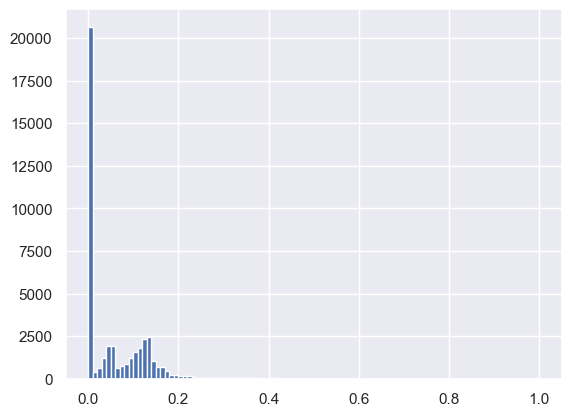

In [25]:
# Plot a histogram of a variable with 100 bins
plt.hist(loan_data_defaults['recovery_rate'], bins = 100)

(array([2.1023e+04, 1.8370e+03, 3.8730e+03, 1.3940e+03, 2.1330e+03,
        3.3440e+03, 4.7650e+03, 1.7130e+03, 1.1790e+03, 4.0600e+02,
        3.4100e+02, 2.7400e+02, 1.1700e+02, 9.3000e+01, 8.1000e+01,
        7.3000e+01, 5.4000e+01, 7.2000e+01, 5.7000e+01, 3.0000e+01,
        4.7000e+01, 2.7000e+01, 1.7000e+01, 1.5000e+01, 2.0000e+01,
        2.3000e+01, 1.7000e+01, 7.0000e+00, 1.1000e+01, 7.0000e+00,
        8.0000e+00, 7.0000e+00, 7.0000e+00, 8.0000e+00, 7.0000e+00,
        1.0000e+01, 6.0000e+00, 1.1000e+01, 9.0000e+00, 9.0000e+00,
        6.0000e+00, 6.0000e+00, 6.0000e+00, 3.0000e+00, 9.0000e+00,
        9.0000e+00, 1.5000e+01, 8.0000e+00, 9.0000e+00, 3.3000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

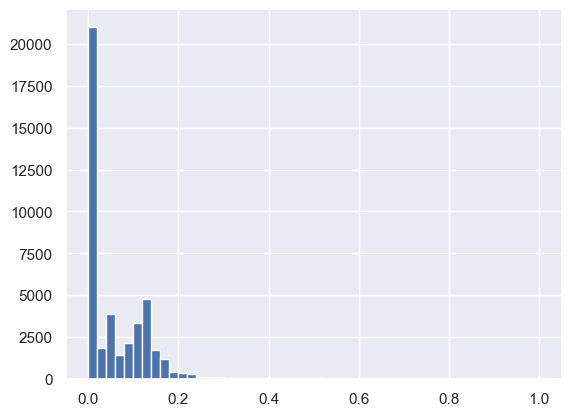

In [26]:
# Plot a histogram of a variable with 50 bins
plt.hist(loan_data_defaults['recovery_rate'], bins = 50)

We can see that half of the observations have a recovery rate of 0, while the rest of recovery rates are greater than 0. So for estimating LGD, it's plausible to have a two-stage approach:
1) Is recovery rate equal to 0 or greater than 0? **(Logistic Regression)**
2) If the recovery rate is greater than 0, how much exactly is it? **(Linear Regression)**

(array([   3.,   17.,   16.,   44.,   16.,   13.,   71.,   26.,    7.,
          63.,   67.,   17.,   60.,   90.,   23.,   55.,   82.,   42.,
          47.,  123.,   82.,   70.,  122.,   86.,   89.,  110.,  117.,
         111.,  122.,  120.,  135.,  141.,  154.,  146.,  160.,  175.,
         152.,  187.,  202.,  174.,  204.,  208.,  210.,  211.,  241.,
         264.,  281.,  224.,  308.,  267.,  287.,  296.,  340.,  274.,
         365.,  370.,  392.,  364.,  393.,  419.,  411.,  429.,  445.,
         497.,  481.,  478.,  569.,  568.,  599.,  618.,  727.,  691.,
         626.,  805.,  804.,  776.,  881.,  851.,  916.,  934.,  925.,
        1078.,  933., 1218., 1041., 1082., 1336., 1040., 1374., 1073.,
        1406., 1287.,  952., 1414.,  795., 1320.,  578.,  949.,  343.,
         531.]),
 array([4.3800000e-04, 1.0433620e-02, 2.0429240e-02, 3.0424860e-02,
        4.0420480e-02, 5.0416100e-02, 6.0411720e-02, 7.0407340e-02,
        8.0402960e-02, 9.0398580e-02, 1.0039420e-01, 1.1038982e-01

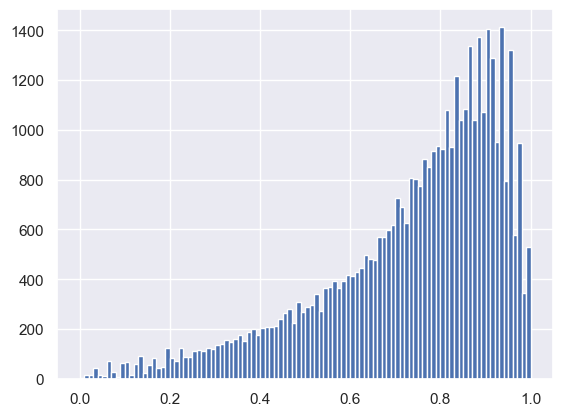

In [27]:
# Plot a histogram of a variable with 100 bins
plt.hist(loan_data_defaults['CCF'], bins = 100)

For EAD, credit conversion factors are more homogeneously distributed. Directly applying a linear regression would produce satisfactory results. Thus, we'll use a multiple linear regeession model for credit conversion factors.

In [28]:
# Create a new variable which is 0 if recovery rate is 0 and 1 otherwise
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)

C:\Users\My Pham\AppData\Local\Temp\ipykernel_2512\651558296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)


In [29]:
# loan_data_defaults['recovery_rate_0_1']

## LGD Model

**Splitting Data**

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
# LGD model stage 1 datasets: recovery rate 0 or greater than 0
# Take a set of inputs and a set of targets as arguments
# Split the inputs and the targets into four dataframes: Inputs - Train, Inputs - Test, Targets - Train, Targets - Test
lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, lgd_targets_stage_1_train, lgd_targets_stage_1_test = train_test_split(loan_data_defaults.drop(['good_bad', 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['recovery_rate_0_1'], test_size = 0.2, random_state = 42)

**Preparing the Inputs**

In [32]:
# List of all independent variables for the models
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

In any regression model, a categorical variable with k categories is represented by (k-1) dummy variables.

In [33]:
# List of the dummy variable reference categories
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

In [34]:
# Keep only the variables we need for the model
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[features_all]

In [35]:
# Rremove the dummy variable reference categories
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train.drop(features_reference_cat, axis = 1)

In [36]:
# Check for missing values: check whether the value of each row for each column is missing or not, then sum accross columns
lgd_inputs_stage_1_train.isnull().sum()

grade:A                                0
grade:B                                0
grade:C                                0
grade:D                                0
grade:E                                0
grade:F                                0
home_ownership:MORTGAGE                0
home_ownership:NONE                    0
home_ownership:OTHER                   0
home_ownership:OWN                     0
verification_status:Not Verified       0
verification_status:Source Verified    0
purpose:car                            0
purpose:debt_consolidation             0
purpose:educational                    0
purpose:home_improvement               0
purpose:house                          0
purpose:major_purchase                 0
purpose:medical                        0
purpose:moving                         0
purpose:other                          0
purpose:renewable_energy               0
purpose:small_business                 0
purpose:vacation                       0
purpose:wedding 

**Estimating the Model**

In [37]:
# P values for sklearn logistic regression

# Class to display p-values for logistic regression in sklearn

from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args, **kwargs, solver='lbfgs', max_iter=1000)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        # Get p-values for the fitted model ####
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        #self.z_scores = z_scores
        self.p_values = p_values
        #self.sigma_estimates = sigma_estimates
        #self.F_ij = F_ij

In [38]:
# Create an instance of an object from the 'LogisticRegression' class
reg_lgd_st_1 = LogisticRegression_with_p_values()
# Estimate the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe
reg_lgd_st_1.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)

In [39]:
# Store the names of the columns of a dataframe in a variable
feature_name = lgd_inputs_stage_1_train.columns.values

In [40]:
# Create a dataframe with a column titled 'Feature name' and row values contained in the 'feature_name' variable
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' object.
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
# Increase the index of every row of the dataframe with 1
summary_table.index = summary_table.index + 1
# Assign values of the row with index 0 of the dataframe
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
# Sort the dataframe by index
summary_table = summary_table.sort_index()
# Take the result of the newly added method 'p_values' and store it in a variable 'p_values'
p_values = reg_lgd_st_1.p_values
# Add the value 'NaN' in the beginning of the variable with p-values
p_values = np.append(np.nan,np.array(p_values))
# In the 'summary_table' dataframe, we add a new column, called 'p_values', containing the values from the 'p_values' variable
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-3.973690e-04,NaN
1,grade:A,-6.169026e-05,9.994249e-01
2,grade:B,-2.658884e-04,9.969272e-01
3,grade:C,-4.130112e-04,9.950468e-01
4,grade:D,4.209150e-05,9.995148e-01
5,grade:E,4.914271e-05,9.994863e-01
6,grade:F,2.153949e-04,9.980403e-01
7,home_ownership:MORTGAGE,-9.156647e-05,9.971438e-01
8,home_ownership:NONE,2.464211e-06,9.999976e-01
9,home_ownership:OTHER,-3.089714e-07,9.999994e-01


Most of these aren't statistically significant. This means if we throw these variables out of the model, its predictive power would remain unchanged, or we can keep them. More ofthen that not, we prefer to leave them out in order to simplify the model.

Here we also have continuous variables. Their coefficients reflect the change in log-odds that results from a unit change in the property the continuous variable measures. 

For every unit increase in funded amount, the logarithm of odds of recovery rate will increase by 0.0001.

For every unit increase in debt-to-income, the log-odds of recovery rate will decrease by 0.0169.

In [41]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_1.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-3.973690e-04,NaN
1,grade:A,-6.169026e-05,9.994249e-01
2,grade:B,-2.658884e-04,9.969272e-01
3,grade:C,-4.130112e-04,9.950468e-01
4,grade:D,4.209150e-05,9.995148e-01
5,grade:E,4.914271e-05,9.994863e-01
6,grade:F,2.153949e-04,9.980403e-01
7,home_ownership:MORTGAGE,-9.156647e-05,9.971438e-01
8,home_ownership:NONE,2.464211e-06,9.999976e-01
9,home_ownership:OTHER,-3.089714e-07,9.999994e-01


**Testing the Model**

In [42]:
# Keep only the variables we need for the model
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[features_all]

In [43]:
# Rremove the dummy variable reference categories
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test.drop(features_reference_cat, axis = 1)

In [44]:
# Calculate the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument
y_hat_test_lgd_stage_1 = reg_lgd_st_1.model.predict(lgd_inputs_stage_1_test)

In [45]:
y_hat_test_lgd_stage_1

array([1, 1, 0, ..., 1, 1, 0])

It would be even better to get the estimated probabilities.

In [46]:
# Calculate the predicted probability values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument
y_hat_test_proba_lgd_stage_1 = reg_lgd_st_1.model.predict_proba(lgd_inputs_stage_1_test)

In [47]:
# This is an array of arrays of predicted class probabilities for all classes
# In this case, the first value of every sub-array is the probability for the observation to belong to the first class, i.e. 0,
# and the second value is the probability for the observation to belong to the first class, i.e. 1
y_hat_test_proba_lgd_stage_1

array([[0.41784975, 0.58215025],
       [0.370094  , 0.629906  ],
       [0.59798349, 0.40201651],
       ...,
       [0.49903167, 0.50096833],
       [0.4179309 , 0.5820691 ],
       [0.55134219, 0.44865781]])

In [48]:
# Take all the arrays in the array, and from each array, we take all rows, and only the element with index 1 (the second element)
# In other words, take only the probabilities for being 1
y_hat_test_proba_lgd_stage_1 = y_hat_test_proba_lgd_stage_1[: ][: , 1]

In [49]:
y_hat_test_proba_lgd_stage_1

array([0.58215025, 0.629906  , 0.40201651, ..., 0.50096833, 0.5820691 ,
       0.44865781])

In [50]:
lgd_targets_stage_1_test_temp = lgd_targets_stage_1_test

In [51]:
# Reset the index of a dataframe
lgd_targets_stage_1_test_temp.reset_index(drop = True, inplace = True)

In [52]:
# Concatenate two dataframes
df_actual_predicted_probs = pd.concat([lgd_targets_stage_1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_stage_1)], axis = 1)

In [53]:
df_actual_predicted_probs.columns = ['lgd_targets_stage_1_test', 'y_hat_test_proba_lgd_stage_1']

In [54]:
# Make the index of one dataframe equal to the index of another dataframe
df_actual_predicted_probs.index = lgd_inputs_stage_1_test.index

In [55]:
df_actual_predicted_probs.head()

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
178928,1,0.582150
69814,1,0.629906
101396,0,0.402017
463268,1,0.555635
253729,0,0.422742


**Estimating the Аccuracy of the Мodel**

In [56]:
# Create a new column with an indicator, where every observation that has predicted probability greater than the threshold has a value of 1,
# and every observation that has predicted probability lower than the threshold has a value of 0
tr = 0.5
df_actual_predicted_probs['y_hat_test_lgd_stage_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'] > tr, 1, 0)

In [57]:
# Create a Confusion Matrix cross-table where the actual values are displayed by rows and the predicted values by columns
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,1531,2231
1,1062,3824


At the default 0.5 cut-off, 1531 0's are currently classified. However, 2231 are incorrectly classified as being greater than 0. As for the 1's, 3824 are correctly classified as being greater tha 0, while only 1062 are incorrectly classified as being equal to 0.

In [58]:
# Divide each value of the table by the total number of observations, thus getting percentages, or, rates
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.177035,0.257979
1,0.122803,0.442183


In [59]:
# Calculate Accuracy of the model, which is the sum of the diagonal rates
(pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]

0.619218316373728

The overall accuracy of the model is about 62%. Overall, the model is not that great. From the PD model, accuracy at a given cut-off is not as informative for model performance as the ROC curve, which shows the true positive rate as a function of the false positive rate, essentially covering all possible cut-off points.

In [60]:
from sklearn.metrics import roc_curve, roc_auc_score

In [61]:
# Return the Receiver Operating Characteristic (ROC) Curve from a set of actual values and their predicted probabilities
# As a result, we get three arrays: the false positive rates, the true positive rates, and the thresholds.
# Store each of the three arrays in a separate variable
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])

Text(0.5, 1.0, 'ROC curve')

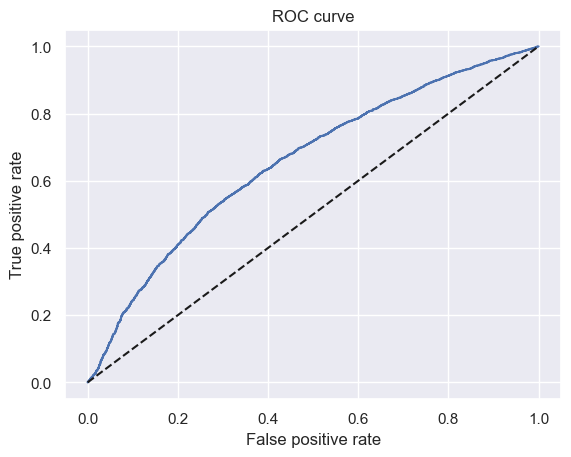

In [62]:
# Plot the false positive rate along the x-axis and the true positive rate along the y-axis, thus plotting the ROC curve
plt.plot(fpr, tpr)
# Plot a seconary diagonal line, with dashed line style and black color
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
# Name the x-axis "False positive rate"
plt.xlabel('False positive rate')
# Name the x-axis "True positive rate"
plt.ylabel('True positive rate')
# Name the graph "ROC curve"
plt.title('ROC curve')

In [63]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) from a set of actual values and their predicted probabilities
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
AUROC

0.6570575196348081

The value of the area under the curve is good, but not greate. However, the important thing here is to remember that we're going to use this model as the first stage os estimating LGD. 

Durin the second stage, some of the values, classified as >1 may be estimated to be =0, thus correcting the current misclassification. Therefore, it's far more important to have a larger, correctly classified proportion of values greater than 0, than to have correctly classified 0's.

**Saving the Model**

In [64]:
import pickle

In [65]:
# Export our model to a 'SAV' file with file name 'lgd_model_stage_1.sav'
pickle.dump(reg_lgd_st_1, open('lgd_model_stage_1.sav', 'wb')) # write bytes

## Stage 2 – Multiple Linear Regression

In [66]:
# Take only rows where the original recovery rate variable is greater than one (eg. where the indicator variable we created is equal to 1)
lgd_stage_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]

In [67]:
# LGD model stage 2 datasets: how much more than 0 is the recovery rate
# Take a set of inputs and a set of targets as arguments. Splits the inputs and the targets into four dataframes:
# Inputs - Train, Inputs - Test, Targets - Train, Targets - Test.
lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, lgd_targets_stage_2_train, lgd_targets_stage_2_test = train_test_split(lgd_stage_2_data.drop(['good_bad', 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), lgd_stage_2_data['recovery_rate'], test_size = 0.2, random_state = 42)

In [68]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [69]:
# Since the p-values are obtained through certain statistics, we need the 'stat' module from scipy.stats
import scipy.stats as stat

# Since we are using an object oriented language such as Python, we can simply define our own 
# LinearRegression class (the same one from sklearn)
# By typing the code below we will ovewrite a part of the class with one that includes p-values
# Here's the full source code of the ORIGINAL class: https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/linear_model/base.py#L362


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    
    # nothing changes in __init__
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1, positive=False):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs
        self.positive = positive
    
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        
        # Calculate SSE (sum of squared errors)
        # and SE (standard error)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        # compute the t-statistic for each feature
        self.t = self.coef_ / se
        # find the p-value for each feature
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [70]:
# Code to use
# import scipy.stats as stat

# class LinearRegression(linear_model.LinearRegression):
#     def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
#                  n_jobs=1, positive=False):
#         self.fit_intercept = fit_intercept
#         self.normalize = normalize
#         self.copy_X = copy_X
#         self.n_jobs = n_jobs
#         self.positive = positive
#     def fit(self, X, y, n_jobs=1):
#         self = super(LinearRegression, self).fit(X, y, n_jobs)
#         sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
#         se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
#         self.t = self.coef_ / se
#         self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
#         return self

In [71]:
# Keep only the variables we need for the model
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[features_all]

In [72]:
# Remove the dummy variable reference categories
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train.drop(features_reference_cat, axis = 1)

In [73]:
# Create an instance of an object from the 'LogisticRegression' class
reg_lgd_st_2 = LinearRegression()
# Estimate the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe
reg_lgd_st_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train)

LinearRegression()

In [74]:
# Store the names of the columns of a dataframe in a variable
feature_name = lgd_inputs_stage_2_train.columns.values

In [75]:
# Create a dataframe with a column titled 'Feature name' and row values contained in the 'feature_name' variable
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe 'Coefficients' with row values the transposed coefficients from the 'LogisticRegression' object
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
# Increase the index of every row of the dataframe with 1
summary_table.index = summary_table.index + 1
# Assign values of the row with index 0 of the dataframe
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
# Sort the dataframe by index
summary_table = summary_table.sort_index()
# Take the result of the newly added method 'p_values' and store it in a variable 'p_values'
p_values = reg_lgd_st_2.p
# Add the value 'NaN' in the beginning of the variable with p-values
p_values = np.append(np.nan,np.array(p_values))
# In the 'summary_table' dataframe, add a new column, called 'p_values', containing the values from the 'p_values' variable
summary_table['p_values'] = p_values.round(3)
summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.406858e-01,NaN
1,grade:A,-6.826892e-02,0.000
2,grade:B,-5.083556e-02,0.000
3,grade:C,-3.748066e-02,0.000
4,grade:D,-2.717310e-02,0.000
5,grade:E,-1.315941e-02,0.002
6,grade:F,-5.260168e-03,0.275
7,home_ownership:MORTGAGE,2.832212e-03,0.061
8,home_ownership:NONE,1.459035e-01,0.000
9,home_ownership:OTHER,-9.475922e-03,0.644


Here the regression coefficients are statistically significant. Unlike the logistic regression, the interpretation of the coefficients is much easier: the change in the dependent variable as a rsult of a unit change in the respective independent variable.

For example, if the purpose of the loan is education, it is expected that the recovery rate would be 7.63% higher.

Also, each dollar incrrease in annual income is expected to result in 0.0000064% higher in recovery rate.

Moreover, every percentage increase in interest rate is expected to result in 2.545% lower recovery.

In [76]:
# Code to use
# summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
# summary_table.index = summary_table.index + 1
# summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
# summary_table = summary_table.sort_index()
# p_values = reg_lgd_st_2.p
# p_values = np.append(np.nan,np.array(p_values))
# summary_table['p_values'] = p_values.round(3)
# summary_table

## Stage 2 – Linear Regression Evaluation

In [77]:
# Keep only the variables we need for the model
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[features_all]

In [78]:
# Remove the dummy variable reference categories
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test.drop(features_reference_cat, axis = 1)

In [79]:
# Calculate the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument
lgd_inputs_stage_2_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [80]:
# Calculate the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument
y_hat_test_lgd_stage_2 = reg_lgd_st_2.predict(lgd_inputs_stage_2_test)

In [81]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test

In [82]:
# Reset the index of a dataframe
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test_temp.reset_index(drop = True)

In [83]:
# Calculate the correlation between actual and predicted values
pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2)], axis = 1).corr()

,recovery_rate,0
recovery_rate,1.000000,0.307996
0,0.307996,1.000000


If the correlation was too high, we'd have actually questioned our methodology.

Let's assess the model by a different way by looking at the distribution of the differences between actual and predicted values called residuals.

C:\Users\My Pham\AppData\Local\Temp\ipykernel_2512\1085691586.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)


<Axes: xlabel='recovery_rate', ylabel='Density'>

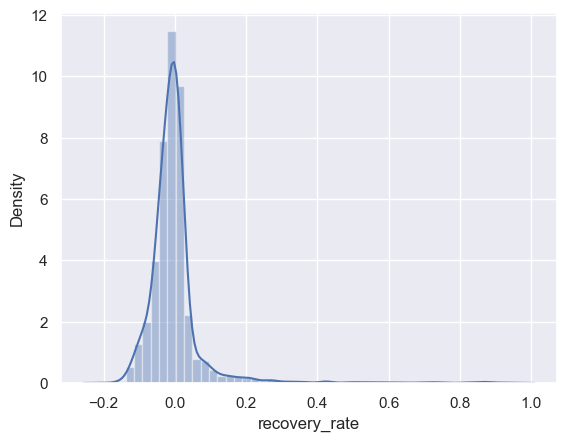

In [84]:
# Plot the distribution of the residuals
sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)

In [85]:
# Export our model to a 'SAV' file with file name 'lgd_model_stage_1.sav'
pickle.dump(reg_lgd_st_2, open('lgd_model_stage_2.sav', 'wb'))

**Combining Stage 1 and Stage 2 to reach the actual LGD model**

**Recover Rate > 0?** (Logistic Regression)
- Stage 1: No: Recovery Rate = 0
  - Every observation classified as 0 has estimated recovery rate of 0
  - Every observation classified as 1 has estimated recovery rate as per Stage 2 linear regression model
- Stage 2: Yes: Estimate Recovery Rate (Linear Regression)

We can reach the combined estimation by simply multiplying the predicted values from the two models.

Wherever there is a 0 predicted by the first model, all values predicted by the second model are multiplied by it will remain 0. Wherever there is a 1, all values predicted by the second model are multiplied by 1, so they'll remain the same.

Recovery rates, estimated by the linear regression, no matter if they were predicted to be 0 or 1 by the first stage are as below:

In [86]:
y_hat_test_lgd_stage_2_all = reg_lgd_st_2.predict(lgd_inputs_stage_1_test)

In [87]:
y_hat_test_lgd_stage_2_all

array([0.1193906 , 0.09605635, 0.13367631, ..., 0.12078611, 0.11587422,
       0.15667447])

In [88]:
# Combine the predictions of the models from the two stages
y_hat_test_lgd = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all

In [89]:
# Show some descriptive statisics for the values of a column
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.072721
std,0.052894
min,-0.007634
25%,0.000000
50%,0.090186
75%,0.115129
max,0.236973


The linear regression model is not constrainted to produce only predictions between 0 and 1.

In [90]:
# Set predicted values that are greater than 1 to 1 and predicted values that are less than 0 to 0
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)

In [91]:
# Show some descriptive statisics for the values of a column
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.072723
std,0.052891
min,0.000000
25%,0.000000
50%,0.090186
75%,0.115129
max,0.236973


## EAD Model

The dependent variable for the EAD model is the credit conversion factor (CCF) - the proportion from the original amount of the loan that is still outstanding at the moment when the borrower defaulted.

When we investigated the distribution of credit conversion factors, we concluded that we can rely only a simple linear regression model.

**Estimation and Interpretation**

In [92]:
# EAD model datasets
# Take a set of inputs and a set of targets as arguments, split the inputs and the targets into four dataframes:
# Inputs - Train, Inputs - Test, Targets - Train, Targets - Test
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop(['good_bad', 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['CCF'], test_size = 0.2, random_state = 42)

In [93]:
ead_inputs_train.columns.values

array(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'member_id', 'loan_amnt',
       'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_join

A categorical variable with K categories is represented by only (K-1) dummy variables. We'll have to leave one dummy variable for each categorical predictor to serve as a reference category, just like we did for the LGD model.

Here we have 5 categorical variables. For the EAD model, it doesn't matter which category is the reference one. For convenience, we can employ the same reference categories as we did for the LGD model.

In [94]:
# Keep only the variables we need for the model
ead_inputs_train = ead_inputs_train[features_all]

In [95]:
# Remove the dummy variable reference categories
ead_inputs_train = ead_inputs_train.drop(features_reference_cat, axis = 1)

In [96]:
# Create an instance of an object from the 'LogisticRegression' class
reg_ead = LinearRegression()
# Estimate the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe
reg_ead.fit(ead_inputs_train, ead_targets_train)

LinearRegression()

In [97]:
feature_name = ead_inputs_train.columns.values

In [98]:
# Create a dataframe with a column titled 'Feature name' and row values contained in the 'feature_name' variable
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe 'Coefficients' with row values the transposed coefficients from the 'LogisticRegression' object.
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
# Increase the index of every row of the dataframe with 1
summary_table.index = summary_table.index + 1
# Assign values of the row with index 0 of the dataframe
summary_table.loc[0] = ['Intercept', reg_ead.intercept_]
# Sort the dataframe by index.
summary_table = summary_table.sort_index()
# Take the result of the newly added method 'p_values' and store it in a variable 'p_values'
p_values = reg_lgd_st_2.p
# Add the value 'NaN' in the beginning of the variable with p-values
p_values = np.append(np.nan,np.array(p_values))
# In the 'summary_table' dataframe, add a new column, called 'p_values', containing the values from the 'p_values' variable
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.109746e+00,NaN
1,grade:A,-3.030033e-01,0.000000e+00
2,grade:B,-2.364277e-01,0.000000e+00
3,grade:C,-1.720232e-01,0.000000e+00
4,grade:D,-1.198470e-01,1.970202e-12
5,grade:E,-6.768713e-02,1.918578e-03
6,grade:F,-2.045907e-02,2.748685e-01
7,home_ownership:MORTGAGE,-6.343341e-03,6.050271e-02
8,home_ownership:NONE,-5.539064e-03,9.092582e-05
9,home_ownership:OTHER,-2.426052e-03,6.436926e-01


By definition, the credit conversion factor is the proportion of the loan that is still outstanding at the moment when the borrower defaults if they default. Therefore, higher CCF indicate that the amount of exposure at the moment the borrower defaults would be higher.
- Positive coefficients = Increase in the CCF (higher risk)
- Negative coefficients = Decrease in the CCF (lower risk)

For example, if a borrower has an external credit rating grade A, their CCF is expected to be about 30% lower than the CCF they'd have with an external grade G since G is the reference category.

Similarly, if their external grade is B, their CCF is expected to be about 23.6% lower than the one they'd have with an external grade G or about 6.6% higher compared to an external grade A.

Notably, if the purpose of the loan is educational, the CCF is expected to be more than 9.6% higher than the CCF for a credit card, which is the reference category.

The increase in CCF, if the purpose was education, is also considerably higher compared to any other purpose of the loan. It may be best that borrowers are those that invest in their education.

For continuous variables, with each percentage increase of interest rate, the expected CCF would be about 1.17%. With every inquiry in the last 6 months, the expected CCF would be able 1.13% higher.

**Model Validation**

In [99]:
# Keep only the variables we need for the model
ead_inputs_test = ead_inputs_test[features_all]

In [100]:
# remove the dummy variable reference categories
ead_inputs_test = ead_inputs_test.drop(features_reference_cat, axis = 1)

In [101]:
ead_inputs_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

To assess how well the model predicts actual values, we'll calculate the correlation between actual and predicted values, just like we did for the second stage of the LGD model.

In [102]:
# Calculate the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument
y_hat_test_ead = reg_ead.predict(ead_inputs_test)

In [103]:
ead_targets_test_temp = ead_targets_test

In [104]:
# reset the index of a dataframe
ead_targets_test_temp = ead_targets_test_temp.reset_index(drop = True)

In [105]:
# calculate the correlation between actual and predicted values
pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()

,CCF,0
CCF,1.000000,0.530654
0,0.530654,1.000000


This is a strong correlation. To make sure our linear regression is okay, we can also look at the distribution of the residuals (differences between actual and predicted values).

C:\Users\My Pham\AppData\Local\Temp\ipykernel_2512\3026573283.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ead_targets_test - y_hat_test_ead)


<Axes: xlabel='CCF', ylabel='Density'>

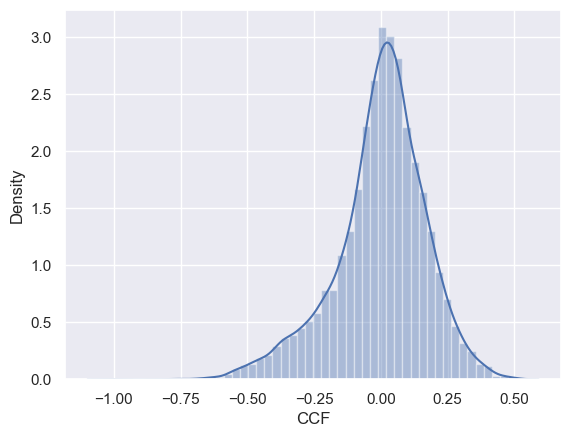

In [106]:
# plot the distribution of the residuals
sns.distplot(ead_targets_test - y_hat_test_ead)

The distribution resembles a normal distribution and most of the residuals are symmetrically distributed around 0. Most of them are concentrated there as well, so the model's predictive power is relative good and it seems to be a very good model.

In [107]:
# Show some descriptive statisics for the values of a column
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.736013
std,0.105194
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.161088


In [108]:
# set predicted values that are greater than 1 to 1 and predicted values that are less than 0 to 0
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)

In [109]:
# Show some descriptive statisics for the values of a column
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.735992
std,0.105127
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.000000


## Expected Loss
$$EL=PD\times LGD\times EAD$$
Banks don't really care about the loss they'll experience from a single borrower. It is negligible compared to their overall exposure. That's why we'd much rather find the total expected loss across all borrowers.

The total expected loss is the sum of the expected loss of all accounts.

**LGD Model**

In [110]:
loan_data_preprocessed.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,0,0,0,0,0,0,1,0,1
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,1,0,0
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,0,0,0,0,0,1,0,1
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,0,0,0,0,0,1,0,1
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,0,0,0,0,0,1,0,1


In [111]:
# Fill the missing values with zeroes
loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)

In [112]:
# Fill the missing values with zeroes
loan_data_preprocessed['mths_since_last_record'].fillna(0, inplace = True)

In [113]:
# Keep only the variables we need for the model
loan_data_preprocessed_lgd_ead = loan_data_preprocessed[features_all]

In [114]:
# Remove the dummy variable reference categories
loan_data_preprocessed_lgd_ead = loan_data_preprocessed_lgd_ead.drop(features_reference_cat, axis = 1)

In [115]:
# Apply the stage 1 LGD model and calculate predicted values
loan_data_preprocessed['recovery_rate_st_1'] = reg_lgd_st_1.model.predict(loan_data_preprocessed_lgd_ead)

In [116]:
# Apply the stage 2 LGD model and calculate predicted values
loan_data_preprocessed['recovery_rate_st_2'] = reg_lgd_st_2.predict(loan_data_preprocessed_lgd_ead)

In [117]:
# Combine the predicted values from the stage 1 predicted model and the stage 2 predicted model to calculate the final estimated recovery rate
loan_data_preprocessed['recovery_rate'] = loan_data_preprocessed['recovery_rate_st_1'] * loan_data_preprocessed['recovery_rate_st_2']

In [118]:
# Set estimated recovery rates that are greater than 1 to 1 and  estimated recovery rates that are less than 0 to 0
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] < 0, 0, loan_data_preprocessed['recovery_rate'])
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] > 1, 1, loan_data_preprocessed['recovery_rate'])

In [119]:
# Calculate estimated LGD. Estimated LGD equals 1 - estimated recovery rate
loan_data_preprocessed['LGD'] = 1 - loan_data_preprocessed['recovery_rate']

In [120]:
# Show some descriptive statisics for the values of a column
loan_data_preprocessed['LGD'].describe()

count    466285.000000
mean          0.932034
std           0.058262
min           0.357914
25%           0.880458
50%           0.913617
75%           1.000000
max           1.000000
Name: LGD, dtype: float64

**EAD Model**

$$\text{EAD = CCF x Funded Amount}$$

In [121]:
# Apply the EAD model to calculate estimated credit conversion factor
loan_data_preprocessed['CCF'] = reg_ead.predict(loan_data_preprocessed_lgd_ead)

In [122]:
# Set estimated CCF that are greater than 1 to 1 and  estimated CCF that are less than 0 to 0
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] < 0, 0, loan_data_preprocessed['CCF'])
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] > 1, 1, loan_data_preprocessed['CCF'])

In [123]:
# Calculate estimated EAD. Estimated EAD equals estimated CCF multiplied by funded amount
loan_data_preprocessed['EAD'] = loan_data_preprocessed['CCF'] * loan_data_preprocessed_lgd_ead['funded_amnt']

In [124]:
# Show some descriptive statisics for the values of a column
loan_data_preprocessed['EAD'].describe()

count    466285.000000
mean      10814.846760
std        6935.184562
min         190.347372
25%        5495.101413
50%        9208.479591
75%       14692.844549
max       35000.000000
Name: EAD, dtype: float64

In [125]:
loan_data_preprocessed.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad,recovery_rate_st_1,recovery_rate_st_2,recovery_rate,LGD,CCF,EAD
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,1,0,1,1,0.086271,0.086271,0.913729,0.589922,2949.608449
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,1,0,0,1,0.084518,0.084518,0.915482,0.777773,1944.433378
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,1,0,1,1,0.080516,0.080516,0.919484,0.658306,1579.934302
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,1,0,1,1,0.095076,0.095076,0.904924,0.660656,6606.559612
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,1,0,1,1,0.088547,0.088547,0.911453,0.708211,2124.631667


**PD Model** 

For PD, we need an entirely different set of input variables.

In [126]:
# Import data to apply the PD model
loan_data_inputs_train = pd.read_csv('loan_data_inputs_train.csv')

In [127]:
# Import data to apply the PD model
loan_data_inputs_test = pd.read_csv('loan_data_inputs_test.csv')

In [128]:
# Concatenate the two dataframes along the rows
loan_data_inputs_pd = pd.concat([loan_data_inputs_train, loan_data_inputs_test], axis = 0)
loan_data_inputs_pd.shape

(466285, 325)

In [129]:
loan_data_inputs_pd.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
0,427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,...,1,0,0,1,0,0,0,0,0,0
1,206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,...,0,0,0,1,0,0,0,0,0,0
2,136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,...,0,0,0,1,0,0,0,0,0,0
3,412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,...,0,0,0,1,0,0,0,0,0,0
4,36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,...,0,1,0,1,0,0,0,0,0,0


We have to match the rows of the dataframe where we calculated PD with the rows of the dataframe where we calculated LGD and EAD.

In [130]:
# Set the index of the dataframe to the values of a specific column
loan_data_inputs_pd = loan_data_inputs_pd.set_index('Unnamed: 0')
loan_data_inputs_pd.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,A,...,1,0,0,1,0,0,0,0,0,0
206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,C,...,0,0,0,1,0,0,0,0,0,0
136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,A,...,0,0,0,1,0,0,0,0,0,0
412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,D,...,0,0,0,1,0,0,0,0,0,0
36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,C,...,0,1,0,1,0,0,0,0,0,0


We need only the variables that are part of the PD model estimation.

In [131]:
features_all_pd = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>86']

We need to remove one dummy variable for each original category.

In [132]:
ref_categories_pd = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [133]:
# Keep only the variables we need for the model
loan_data_inputs_pd_temp = loan_data_inputs_pd[features_all_pd]

In [134]:
# Remove the dummy variable reference categories
loan_data_inputs_pd_temp = loan_data_inputs_pd_temp.drop(ref_categories_pd, axis = 1)
loan_data_inputs_pd_temp.shape

(466285, 84)

In [140]:
loan_data_inputs_pd_temp.columns

Index(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:OWN', 'home_ownership:MORTGAGE', 'addr_state:NM_VA',
       'addr_state:NY', 'addr_state:OK_TN_MO_LA_MD_NC', 'addr_state:CA',
       'addr_state:UT_KY_AZ_NJ', 'addr_state:AR_MI_PA_OH_MN',
       'addr_state:RI_MA_DE_SD_IN', 'addr_state:GA_WA_OR', 'addr_state:WI_MT',
       'addr_state:TX', 'addr_state:IL_CT', 'addr_state:KS_SC_CO_VT_AK_MS',
       'addr_state:WV_NH_WY_DC_ME_ID', 'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:credit_card',
       'purpose:debt_consolidation', 'purpose:oth__med__vacation',
       'purpose:major_purch__car__home_impr', 'initial_list_status:w',
       'term:36', 'emp_length:1', 'emp_length:2-4', 'emp_length:5-6',
       'emp_length:7-9', 'emp_length:10', 'mths_since_issue_d:<38',
       'mths_since_issue_d:38-39', 'mths_since_issue_d:40-41',
       'mths_since_issue_d:42-48', 'mths_since_issue_d:49-52',
       'mths_si

In [135]:
# Import the PD model, stored in the 'pd_model.sav' file
import pickle
reg_pd = pickle.load(open('pd_model.sav', 'rb'))

We could have imported all three models (PD, LGD and EAD) from the previous notebook with the sole purpose of calculating the expected loss.

In [141]:
# Apply the PD model to caclulate estimated default probabilities
loan_data_inputs_pd_temp = loan_data_inputs_pd_temp.drop(columns=['emp_length:10'])
reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]

array([0.03129721, 0.09328827, 0.04009554, ..., 0.0235125 , 0.04224145,
       0.04935191])

In [142]:
# Apply the PD model to caclulate estimated default probabilities
# The first number of each lower level array is the probability of 0 (probability of default)
# The second one is the probability of 1 (probability of non-default)
loan_data_inputs_pd['PD'] = reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]
loan_data_inputs_pd['PD'].head()

Unnamed: 0
427211    0.031297
206088    0.093288
136020    0.040096
412305    0.201338
36159     0.166730
Name: PD, dtype: float64

In [143]:
# Show some descriptive statisics for the values of a column
loan_data_inputs_pd['PD'].describe()

count    466285.000000
mean          0.107682
std           0.068412
min           0.006042
25%           0.056042
50%           0.092631
75%           0.144272
max           0.528456
Name: PD, dtype: float64

In [144]:
# Concatenate the dataframes where we calculated LGD and EAD and the dataframe where we calculated PD along the columns
loan_data_preprocessed_new = pd.concat([loan_data_preprocessed, loan_data_inputs_pd], axis = 1)
loan_data_preprocessed_new.shape

(466285, 540)

In [145]:
loan_data_preprocessed_new.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86,PD
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,1,0,1,0,0,0,0,0,0,0.176087
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,1,0,0,0,0,0,0,0.257664
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,1,0,0,0,0,0,0,0.244982
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,1,0,0,0,0,0,0,0.209473
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,1,0,0,0,0,0,0,0.125432


In [146]:
# Calculate Expected Loss: EL = PD * LGD * EAD
loan_data_preprocessed_new['EL'] = loan_data_preprocessed_new['PD'] * loan_data_preprocessed_new['LGD'] * loan_data_preprocessed_new['EAD']

In [147]:
# Show some descriptive statisics for the values of a column
loan_data_preprocessed_new['EL'].describe()

count    466285.000000
mean       1085.429185
std        1098.360629
min           1.410032
25%         356.078000
50%         708.228511
75%        1411.846728
max       11619.178756
Name: EL, dtype: float64

The expected loss has a mean of $1,085.

In [148]:
loan_data_preprocessed_new[['funded_amnt', 'PD', 'LGD', 'EAD', 'EL']].head()

,funded_amnt,funded_amnt,PD,LGD,EAD,EL
0,5000,5000,0.176087,0.913729,2949.608449,474.579022
1,2500,2500,0.257664,0.915482,1944.433378,458.666038
2,2400,2400,0.244982,0.919484,1579.934302,355.890991
3,10000,10000,0.209473,0.904924,6606.559612,1252.319957
4,3000,3000,0.125432,0.911453,2124.631667,242.900026


Here we can see the expected loss we calculated for every single loan. For example, the third loan with index 2, the original funded amount is 2,400. We expect we may lose $335.

We can also calculate the total expected loss on the portfolio level by getting the sum of the expected loss column.

In [149]:
loan_data_preprocessed_new['funded_amnt'].describe()

,funded_amnt,funded_amnt
count,466285.000000,466285.000000
mean,14291.801044,14291.801044
std,8274.371300,8274.371300
min,500.000000,500.000000
25%,8000.000000,8000.000000
50%,12000.000000,12000.000000
75%,20000.000000,20000.000000
max,35000.000000,35000.000000


In [150]:
# Total Expected Loss for all loans
loan_data_preprocessed_new['EL'].sum()

506119347.6375786

The total expected loss is about $506M on its own, which doesn't mean much. It makes sense to calculate the expected loss as a proportion of the total funded amount, which is the sum of the funded amount column.

In [151]:
# Total funded amount for all loans
loan_data_preprocessed_new['funded_amnt'].sum()

funded_amnt    6664052450
funded_amnt    6664052450
dtype: int64

The total original funded amount is about $6B. Then the expected loss relative to the total portfolio is the sum of the expected loss divided by the sum of the funded amount.

In [152]:
# Total Expected Loss as a proportion of total funded amount for all loans
loan_data_preprocessed_new['EL'].sum() / loan_data_preprocessed_new['funded_amnt'].sum()

funded_amnt    0.075948
funded_amnt    0.075948
dtype: float64

The proportion is around 7.6%. A bank usually holds 10% of its assets as capital. Therefore, the expected loss on its loan portfolio should be less than its capital. Thus, observed expected loss values are anywhere between 2% and 10%.

Depending on this exposure, the bank management can decide to be more aggressive or more conservative when it comes to giving out loans in the future.